# Discussion on zero padding

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import input_power
import skewer_maker

Define the input power spectrum

In [3]:
input_p1d=input_power.InputPower(P0=1.0,k0=1,kF=10,r_SiIII=20,f_SiIII=0.05)

Define the long FFT grid used to generate skewers

In [4]:
seed=1234
# whole range of FFT grid (larger than the length of a given skewer)
L_long=1000
N_long=2**11
print('long',N_long,L_long,L_long/N_long)
maker=skewer_maker.SkewerMaker(N=N_long,L=L_long,inP=input_p1d,seed=seed)

long 2048 1000 0.48828125


Define the survey window (skewers will only be visible here)

In [5]:
# the window will start at 0, but it doesn't matter (the skewers are periodic)
N_window=N_long//8
L_window=L_long*N_window/N_long
print('window',N_window,L_window,L_window/N_window)

window 256 125.0 0.48828125


In [6]:
# the FFT grid used in the analysis could be different than the window, since we might add zero padding
N=2*N_window
L=L_window*N/N_window
# pixel width 
dx = L/N
print('analysis',N,L,dx)
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
k = np.fft.fftfreq(N)*2*np.pi/dx
print('Delta k =',k[1],2*np.pi/L)
print('k_Ny = ',-k[N//2],np.pi/dx)
# Positions
x = dx*np.arange(N)

analysis 512 250.0 0.48828125
Delta k = 0.025132741228718346 0.025132741228718346
k_Ny =  6.433981754551897 6.433981754551897


In [7]:
# evaluate input P1D in the analysis grid 
true_p1d=input_p1d.get_true_p1d(np.abs(k))

### Analyse multiple skewers

The squared amplitude of the Fourier modes should (on average!) agree with the input power spectrum

In [8]:
# reset seed again
maker.reset_seed()
# measure P1D and variance ( F_m = < |f_m|^2 >)
F_m=np.zeros(N)
var_F_m=np.zeros(N)
# mean of |w_m|^2 (FFT of mask, squared)
w2_m=np.zeros(N)
Nsk=int(1e6)
for i in tqdm(range(Nsk)):
    # create a mask for this particular test
    mask=np.zeros(N)
    mask[:N_window]=1
    # FFT of mask
    w_m = np.fft.fft(mask)
    w2_m += abs(w_m)**2
    # generate random field 
    skewer=maker.make_skewer()
    # keep only those within window, in the FFT grid
    deltas = skewer[:N]
    deltas *= mask
    # and FFT again to obtain masked modes
    f_m=np.fft.fft(deltas)
    p1d = abs(f_m)**2
    F_m += p1d
    var_F_m += p1d**2
# normalize mask
w2_m /= Nsk
# normalize them
F_m /= Nsk
var_F_m /= Nsk
var_F_m -= F_m**2
# correct normalisation based on my notes
mean_p1d = (dx/N) * F_m
err_p1d = (dx/N) * np.sqrt(var_F_m/Nsk)

100%|██████████████████████████████| 1000000/1000000 [00:53<00:00, 18796.73it/s]


(0.0, 0.5)

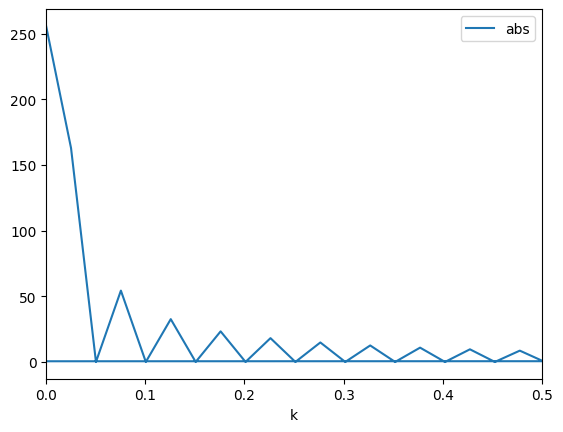

In [9]:
# plot FFT of mask (squared)
plt.plot(k,np.sqrt(w2_m),label='abs')
plt.legend()
plt.xlabel('k')
plt.xlim([0,0.5])

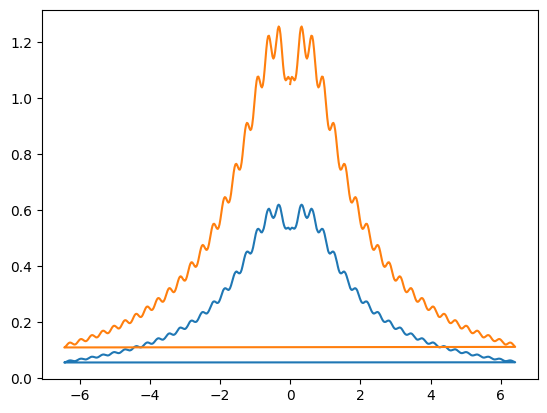

In [10]:
plt.plot(k,mean_p1d)
plt.plot(k,true_p1d)

0.5013898249817654


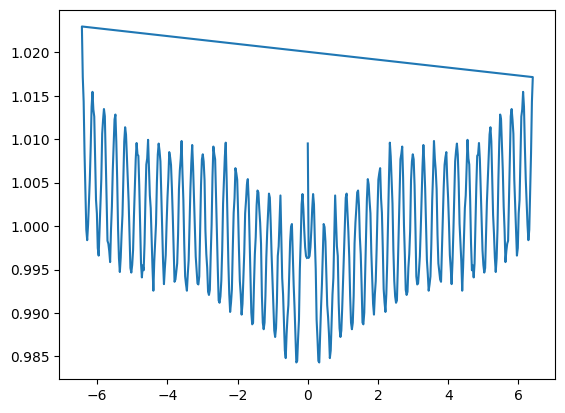

In [11]:
norm=np.mean(mean_p1d/true_p1d)
plt.plot(k,mean_p1d/true_p1d/norm)
print(norm)

### Try to convolve theory with mask

In [12]:
P_m = true_p1d / dx # < |delta_m|^2 >
xi_a = np.fft.ifft(P_m)
Q_a = np.fft.ifft(w2_m)

In [13]:
T_m = np.fft.fft(Q_a*xi_a)

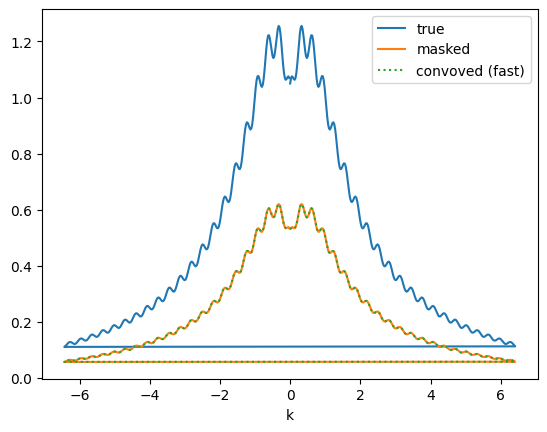

In [14]:
plt.plot(k,true_p1d,label='true')
plt.plot(k,mean_p1d,label='masked')
#plt.plot(k,convolved_p1d/N/N,ls=':',label='convolved')
plt.plot(k,T_m.real*(dx/N),ls=':',label='convoved (fast)')
plt.xlabel('k')
plt.legend()

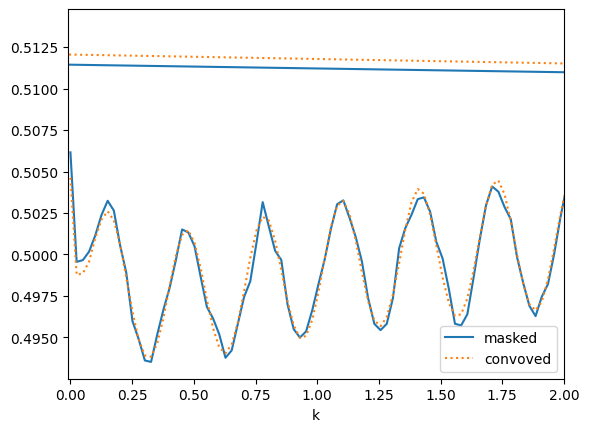

In [15]:
plt.plot(k,mean_p1d/true_p1d,label='masked')
plt.plot(k,T_m.real*(dx/N)/true_p1d,ls=':',label='convoved')
plt.xlabel('k')
plt.xlim([-0.01,2])
plt.legend()

### Rebin power

In [16]:
# we will use band powers defined by the grid of the forest (L/4)
dk_bin=2*np.pi/L_window
print('dk =',dk_bin)
# stop roughly at half the Nyquist frequency for now
k_max=np.pi/dx/2
print('k < ',k_max)
k_edges=np.arange(0.01*dk_bin,k_max+dk_bin,dk_bin)
Nk=k_edges.size-1
print('Nk =',Nk)

dk = 0.05026548245743669
k <  3.2169908772759483
Nk = 64


In [17]:
# define the rebinning vector B_alpha_m in the notes (including negative frequencies!)
B_m=np.zeros([Nk,N])
for i in range(Nk):
    #print(i,k_edges[i],k_edges[i+1])
    inbin=(abs(k)>k_edges[i]) & (abs(k)<k_edges[i+1])
    B_m[i,inbin]=1    

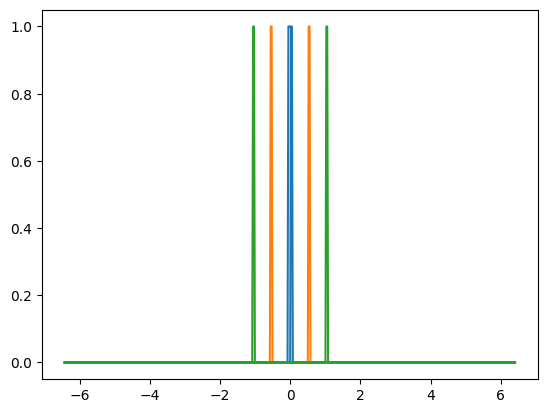

In [18]:
plt.plot(k,B_m[0])
plt.plot(k,B_m[10])
plt.plot(k,B_m[20])

In [19]:
# iFFT B_m to get B_a (for the convolution theorem)
B_a=np.empty([Nk,N])
for i in range(Nk):
    B_a[i]=np.fft.ifft(B_m[i]).real

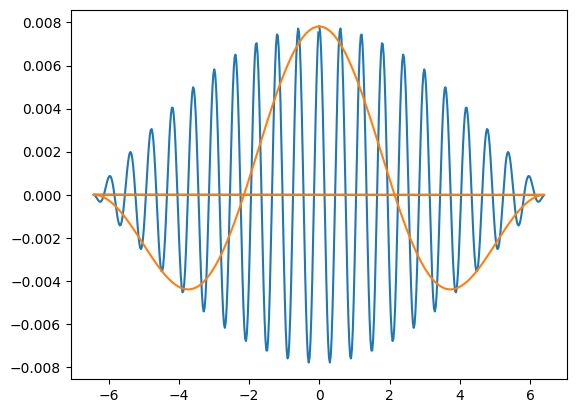

In [20]:
plt.plot(k,B_a[10])
plt.plot(k,B_a[0])

In [21]:
BQ_m=np.empty([Nk,N])
for i in range(Nk):
    BQ_m[i]=np.fft.fft(B_a[i]*Q_a).real

(-0.8042477193189871, 0.8042477193189871)

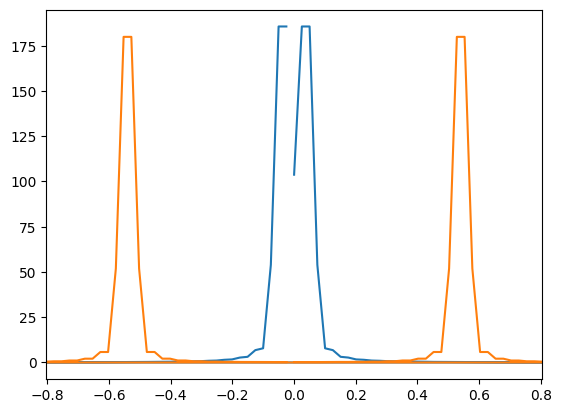

In [22]:
plt.plot(k,BQ_m[0])
plt.plot(k,BQ_m[10])
plt.xlim([-k_max/4,k_max/4])

In [23]:
# normalisation (for this example, this is a constant)
A_A=np.empty(Nk)
# mean k in bin A
k_A=np.zeros_like(A_A)
for i in range(Nk):
    A_A[i]=np.sum(BQ_m[i])/dx
    k_A[i]=np.sum(B_m[i]*abs(k))/np.sum(B_m[i])

In [24]:
# actual summary statistics
Theta_A=np.zeros_like(A_A)
# convolved model
model_A=np.empty(Nk)
for i in range(Nk):
    Theta_A[i]=np.sum(B_m[i]*F_m)/A_A[i]
    model_A[i]=(np.sum(B_m[i]*T_m)/A_A[i]).real

In [25]:
true_p1d_A=input_p1d.get_true_p1d(k_A)

Text(0, 0.5, 'P1D')

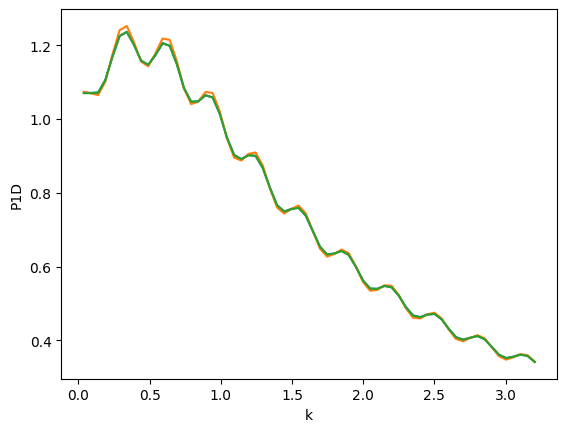

In [26]:
plt.plot(k_A,Theta_A,label='masked measurement')
plt.plot(k_A,true_p1d_A,label='true P1D')
plt.plot(k_A,model_A,label='masked model')
plt.xlabel('k')
plt.ylabel('P1D')

Text(0, 0.5, 'P1D')

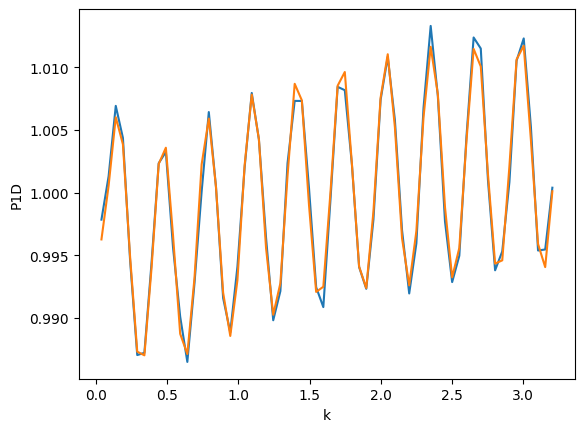

In [27]:
plt.plot(k_A,Theta_A/true_p1d_A,label='masked measurement')
plt.plot(k_A,model_A/true_p1d_A,label='masked model')
#plt.plot(k_A,get_true_p1d(k_A),label='true P1D')
plt.xlabel('k')
plt.ylabel('P1D')